<a href="https://colab.research.google.com/github/giuliaries/object-detection/blob/main/detr_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with DETR

Complete notebook for training and testing DETR models with Roboflow integration.

In [ ]:
# ============================================================
# CHECK GPU availability
# ============================================================

import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  No GPU found - training will be very slow!")

GPU available: True
GPU: Tesla T4
VRAM: 15.64 GB


In [ ]:
# ============================================================
# INSTALL DEPENDENCIES
# ============================================================

%%capture
# Install dependencies (output hidden for clarity)
!pip install -q transformers torch torchvision roboflow supervision pillow matplotlib numpy pyyaml datasets accelerate
!pip install -q torchmetrics seaborn

print("✅ All dependencies installed successfully!")

In [ ]:
# ============================================================
# ROBOFLOW CONFIGURATION
# ============================================================

ROBOFLOW_API_KEY = "Tci79vVpwGbCxMmTBrDt"  # Private API key
ROBOFLOW_WORKSPACE = "university-h35bh"
ROBOFLOW_PROJECT = "cat-npklm-7ijlg"
ROBOFLOW_VERSION = 1                       # Dataset version

# ============================================================
# TRAINING CONFIGURATION
# ============================================================

MODEL_NAME  = "facebook/detr-resnet-50"
OUTPUT_DIR  = "./detr_finetuned"

# Training parameters
NUM_EPOCHS    = 75      # max epochs; early stopping will stop earlier
BATCH_SIZE    = 4       # DETR is memory-heavy; keep at 4
LEARNING_RATE = 1e-4    # transformer layers
BACKBONE_LR   = 1e-5    # 10x lower for ResNet-50 backbone (pre-trained)
NUM_QUERIES   = 100
EVAL_STEPS    = 100     # evaluate every 100 steps
PATIENCE      = 8       # early stopping patience

# ============================================================
# TEST CONFIGURATION
# ============================================================

TEST_IMAGES_DIR = "./test_images"
CONFIDENCE_THRESHOLD = 0.3   # DETR is better calibrated than YOLOS
IOU_THRESHOLD = 0.5

print("✅ Configuration loaded")
print(f"   Model:          {MODEL_NAME}")
print(f"   Epochs:         max {NUM_EPOCHS}, early stopping patience={PATIENCE}")
print(f"   Num queries:    {NUM_QUERIES}  (reduced from default 100)")
print(f"   Backbone LR:    {BACKBONE_LR}  (transformer LR: {LEARNING_RATE})")
print(f"   Confidence thr: {CONFIDENCE_THRESHOLD}")

✅ Configuration loaded
   Model:          facebook/detr-resnet-50
   Epochs:         max 75, early stopping patience=8
   Num queries:    100  (reduced from default 100)
   Backbone LR:    1e-05  (transformer LR: 0.0001)
   Confidence thr: 0.3


In [ ]:
# ============================================================
# IMPORTS
# ============================================================

import os
import json
import torch
import yaml
import supervision as sv
from PIL import Image
from roboflow import Roboflow
from transformers import (
    DetrImageProcessor,
    DetrForObjectDetection,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
import torchvision

import warnings
import logging

# Silence PyTorch warnings
warnings.filterwarnings('ignore', message='.*copying from a non-meta parameter.*')

print("✅ Imports completed")

✅ Imports completed


In [ ]:
# ============================================================
# CUSTOM DATASET
# ============================================================

class RoboflowObjectDetectionDataset(Dataset):
    """Custom dataset for Object Detection with DETR"""

    def __init__(self, data_dir, processor, split='train'):
        self.data_dir = Path(data_dir)
        self.processor = processor
        self.split = split

        self.images_dir = self.data_dir / split / 'images'
        self.labels_dir = self.data_dir / split / 'labels'

        self.classes = self._load_classes()
        self.id2label = {i: label for i, label in enumerate(self.classes)}
        self.label2id = {label: i for i, label in enumerate(self.classes)}

        self.image_files = sorted(list(self.images_dir.glob('*.jpg')) +
                                  list(self.images_dir.glob('*.png')))

        print(f"✅ Dataset loaded: {len(self.image_files)} images in '{split}' set")
        print(f"📋 Classes: {self.classes}")

    def _load_classes(self):
        yaml_path = self.data_dir / 'data.yaml'
        if yaml_path.exists():
            with open(yaml_path, 'r') as f:
                data = yaml.safe_load(f)
                return data['names']
        return []

    def _load_yolo_annotations(self, label_path, img_width, img_height):
        boxes = []
        labels = []

        if not label_path.exists():
            return boxes, labels

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height

                x_min = x_center - width / 2
                y_min = y_center - height / 2

                boxes.append([x_min, y_min, width, height])
                labels.append(class_id)

        return boxes, labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """Returns preprocessed item in DETR format"""
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        img_width, img_height = image.size

        # Load annotations
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        boxes, labels = self._load_yolo_annotations(label_path, img_width, img_height)

        # Prepare target in COCO format for DETR
        target = {}
        target["image_id"] = torch.tensor([idx])
        target["annotations"] = []

        for box, label in zip(boxes, labels):
            x_min, y_min, width, height = box
            target["annotations"].append({
                "bbox": [x_min, y_min, width, height],
                "category_id": label,
                "area": width * height,
                "iscrowd": 0
            })

        # Preprocess with DETR processor
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")

        # Return in the format expected by the trainer
        # pixel_mask is critical for DETR: tells the model where padding is
        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "pixel_mask":   encoding["pixel_mask"].squeeze(0),
            "labels":       encoding["labels"][0]
        }

print("✅ Dataset class defined")

✅ Dataset class defined


In [ ]:
# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def download_roboflow_dataset(api_key, workspace, project, version):
    """Download dataset from Roboflow"""
    print("📥 Downloading dataset from Roboflow...")

    try:
        rf = Roboflow(api_key=api_key)
        project = rf.workspace(workspace).project(project)
        dataset = project.version(version).download("yolov8")

        print(f"✅ Dataset downloaded to: {dataset.location}")
        return dataset.location
    except Exception as e:
        print(f"❌ Error during download: {e}")
        print("\n💡 Check:")
        print("   - API key is correct (use PRIVATE API key)")
        print("   - Workspace, project and version are correct")
        return None

def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """Apply Non-Maximum Suppression to remove duplicate detections"""
    if len(boxes) == 0:
        return boxes, scores, labels

    # Apply NMS per class
    keep_indices = []
    unique_labels = torch.unique(labels)

    for label in unique_labels:
        # Get boxes for this class
        class_mask = labels == label
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]

        # Get original indices
        class_indices = torch.where(class_mask)[0]

        # Apply NMS
        keep = torchvision.ops.nms(class_boxes, class_scores, iou_threshold)
        keep_indices.extend(class_indices[keep].tolist())

    # Sort to maintain order
    keep_indices = sorted(keep_indices)

    return boxes[keep_indices], scores[keep_indices], labels[keep_indices]

def visualize_predictions(image, predictions, processor, threshold=0.5):
    """Visualize predictions on an image"""
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_array)

    scores = predictions["scores"]
    labels = predictions["labels"]
    boxes = predictions["boxes"]

    # Filter by threshold
    keep = scores > threshold
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]

    print(f"   📊 Showing {len(scores)} detections above threshold {threshold}")

    # Generate colors
    num_classes = len(processor.id2label)
    colors = plt.cm.hsv(np.linspace(0, 1, num_classes))

    # Draw each detection
    for score, label, box in zip(scores, labels, boxes):
        x_min, y_min, x_max, y_max = box.cpu().numpy()
        width = x_max - x_min
        height = y_max - y_min

        # Get color for this class
        label_idx = label.item()
        if label_idx < len(colors):
            color = colors[label_idx]
        else:
            color = 'red'

        # Draw bounding box
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        # Add label
        label_name = processor.id2label.get(label_idx) or \
             processor.id2label.get(str(label_idx), f"Class_{label_idx}")
        ax.text(
            x_min, y_min - 5,
            f"{label_name}: {score:.2f}",
            color='white',
            fontsize=10,
            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2)
        )

    ax.axis('off')
    return fig

def save_model_info(model, processor, output_dir):
    """Save model configuration info"""
    info = {
        'num_labels': model.config.num_labels,
        'id2label': processor.id2label,
        'label2id': processor.label2id,
        'model_name': model.config._name_or_path
    }

    with open(os.path.join(output_dir, 'model_info.json'), 'w') as f:
        json.dump(info, f, indent=2)

    print(f"   Model info saved")

print("✅ Utility functions defined")

✅ Utility functions defined


# PART 1: TRAINING

In [ ]:
# ============================================================
# TRAINING: Download Dataset
# ============================================================

print("\n" + "="*70)
print("🏋️ START TRAINING")
print("="*70 + "\n")

dataset_path = download_roboflow_dataset(
    ROBOFLOW_API_KEY,
    ROBOFLOW_WORKSPACE,
    ROBOFLOW_PROJECT,
    ROBOFLOW_VERSION
)

if dataset_path is None:
    raise ValueError("❌ Dataset download failed! Check configuration.")

print(f"\n✅ Dataset ready at: {dataset_path}")


🏋️ START TRAINING

📥 Downloading dataset from Roboflow...
loading Roboflow workspace...
loading Roboflow project...
✅ Dataset downloaded to: /content/cat-1

✅ Dataset ready at: /content/cat-1


In [ ]:
# ============================================================
# TRAINING: Load Model and Dataset
# ============================================================

print("\n📦 Loading pre-trained model...")
processor = DetrImageProcessor.from_pretrained(MODEL_NAME)

print("\n📚 Preparing dataset...")
train_dataset = RoboflowObjectDetectionDataset(
    dataset_path, processor, split='train'
)
val_dataset = RoboflowObjectDetectionDataset(
    dataset_path, processor, split='valid'
)

# Configuration for DETR
# DETR num_labels should be ONLY the number of object classes
# The "no-object" class is handled internally by DETR
num_classes = len(train_dataset.classes)

# Build mappings WITHOUT background class
id2label = {i: label for i, label in enumerate(train_dataset.classes)}
label2id = {label: i for i, label in id2label.items()}

# Update processor
processor.id2label = id2label
processor.label2id = label2id

print(f"\n🔧 Initializing model:")
print(f"   Object classes: {num_classes} ({train_dataset.classes})")
print(f"   num_labels: {num_classes} (background handled internally by DETR)")
print(f"   Class mapping: {id2label}")

# Use num_classes directly, not num_classes + 1
model = DetrForObjectDetection.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    num_queries=NUM_QUERIES,
    ignore_mismatched_sizes=True,
)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✅ DETR model ready — {total_params/1e6:.1f}M parameters")
print(f"   Num queries: {model.config.num_queries}  (was 100 by default)")


📦 Loading pre-trained model...

📚 Preparing dataset...
✅ Dataset loaded: 249 images in 'train' set
📋 Classes: ['Cats']
✅ Dataset loaded: 43 images in 'valid' set
📋 Classes: ['Cats']

🔧 Initializing model:
   Object classes: 1 (['Cats'])
   num_labels: 1 (background handled internally by DETR)
   Class mapping: {0: 'Cats'}


DetrForObjectDetection LOAD REPORT from: facebook/detr-resnet-50
Key                                                                         | Status     |                                                                                      
----------------------------------------------------------------------------+------------+--------------------------------------------------------------------------------------
model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                      
model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                      
model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                      
model.backbone.conv_encoder.model.layer2.0.downsam


✅ DETR model ready — 41.5M parameters
   Num queries: 100  (was 100 by default)


In [ ]:
# ============================================================
# TRAINING: Train Model
# ============================================================

# ── Separate optimizer: low LR for backbone, higher for transformer ───────────
import torch.optim as optim
backbone_params     = list(model.model.backbone.parameters())
backbone_param_ids  = {id(p) for p in backbone_params}
transformer_params  = [p for p in model.parameters() if id(p) not in backbone_param_ids]

optimizer = optim.AdamW([
    {"params": backbone_params,    "lr": BACKBONE_LR},
    {"params": transformer_params, "lr": LEARNING_RATE},
], weight_decay=1e-4)

# ── Collate function: include pixel_mask (required by DETR) ───────────────────
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    pixel_mask   = torch.stack([item["pixel_mask"]   for item in batch])
    labels       = [item["labels"] for item in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "labels": labels}

# ── Training arguments ────────────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir                  = OUTPUT_DIR,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE,
    num_train_epochs            = NUM_EPOCHS,
    learning_rate               = LEARNING_RATE,   # used for scheduler only
    warmup_steps                = 100,
    weight_decay                = 1e-4,
    lr_scheduler_type           = "cosine",
    eval_strategy               = "steps",         # evaluate every EVAL_STEPS
    save_strategy               = "steps",
    eval_steps                  = EVAL_STEPS,
    save_steps                  = EVAL_STEPS,
    save_total_limit            = 2,
    remove_unused_columns       = False,
    push_to_hub                 = False,
    logging_steps               = 20,
    load_best_model_at_end      = True,
    metric_for_best_model       = "eval_loss",
    greater_is_better           = False,
    max_grad_norm               = 0.1,             # gradient clipping — critical for DETR
    fp16                        = torch.cuda.is_available(),
)

trainer = Trainer(
    model         = model,
    args          = training_args,
    train_dataset = train_dataset,
    eval_dataset  = val_dataset,
    data_collator = collate_fn,
    optimizers    = (optimizer, None),             # None = use HF default scheduler
    callbacks     = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

print(f"Starting training — max {NUM_EPOCHS} epochs, early stopping patience={PATIENCE} evals...")
print("This may take 15-30 minutes...\n")

trainer.train()

print("\n💾 Saving final model...")
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
save_model_info(model, processor, OUTPUT_DIR)

print(f"\n{'='*70}")
print("✅ TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"\n📁 Model saved to: {OUTPUT_DIR}")
print("\n💡 Now you can test the model in the TEST section below!")

Starting training — max 75 epochs, early stopping patience=8 evals...
This may take 15-30 minutes...




💾 Saving final model...


   Model info saved

✅ TRAINING COMPLETED!

📁 Model saved to: ./detr_finetuned

💡 Now you can test the model in the TEST section below!


# PART 2: TESTING

Test the trained model on new images.

In [ ]:
# ============================================================
# TEST: Upload Test Images
# ============================================================

# Create test directory
os.makedirs(TEST_IMAGES_DIR, exist_ok=True)

# Upload images from computer
from google.colab import files

print("📤 Upload the images you want to test...")
uploaded = files.upload()

# Move to test_images
for filename in uploaded.keys():
    !mv {filename} {TEST_IMAGES_DIR}/

print(f"\n✅ {len(uploaded)} images uploaded to {TEST_IMAGES_DIR}")

📤 Upload the images you want to test...


Saving cat-0.jpeg to cat-0.jpeg
Saving cat-1.jpeg to cat-1.jpeg
Saving cat-2.jpeg to cat-2.jpeg
Saving cat-3.jpeg to cat-3.jpeg
Saving cat-4.jpeg to cat-4.jpeg
Saving cat-5.jpeg to cat-5.jpeg
Saving cat-6.jpeg to cat-6.jpeg
Saving cat-7.jpeg to cat-7.jpeg
Saving cat-camouflaged-1.jpeg to cat-camouflaged-1.jpeg
Saving cat-camouflaged-2.jpeg to cat-camouflaged-2.jpeg
Saving cat-camouflaged-3.jpeg to cat-camouflaged-3.jpeg
Saving cat-camouflaged-4.jpeg to cat-camouflaged-4.jpeg
Saving cat-camouflaged-5.jpeg to cat-camouflaged-5.jpeg
Saving cat-camouflaged-6.jpeg to cat-camouflaged-6.jpeg
Saving cat-camouflaged-7.jpeg to cat-camouflaged-7.jpeg
Saving cat-camouflaged-8.jpeg to cat-camouflaged-8.jpeg
Saving cat-camouflaged-9.jpeg to cat-camouflaged-9.jpeg
Saving cat-camouflaged-10.jpeg to cat-camouflaged-10.jpeg
Saving cat-camouflaged-11.jpeg to cat-camouflaged-11.jpeg
Saving owl.jpeg to owl.jpeg

✅ 20 images uploaded to ./test_images


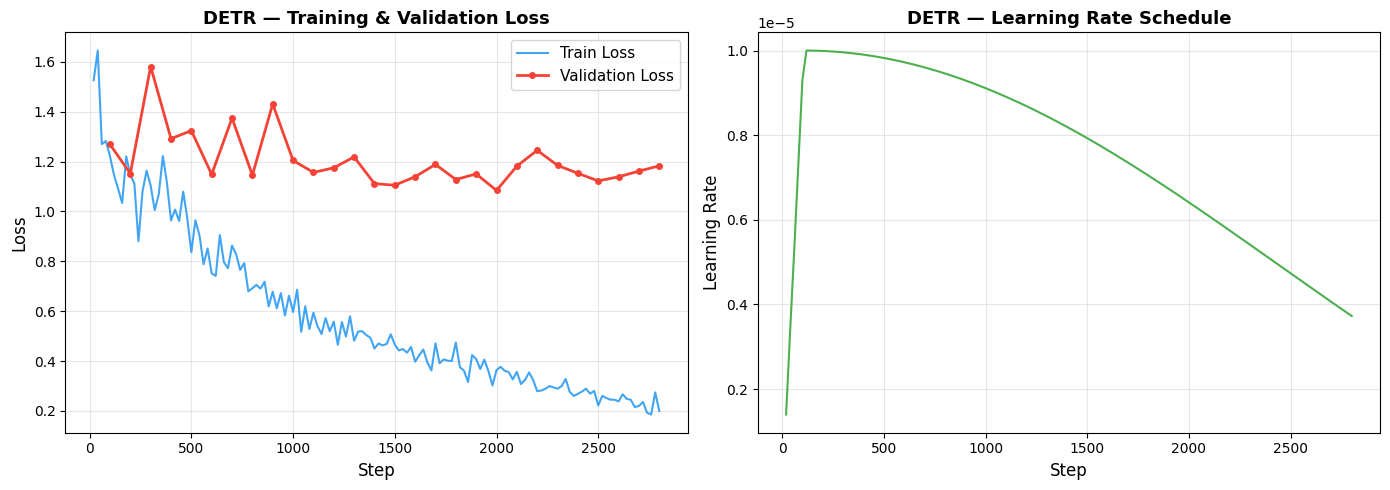


📊 Training Summary
   Total steps    : 2800
   Final train loss: 0.1996
   Best eval loss  : 1.0843  (step 2000)
   Final eval loss : 1.1830


In [ ]:
# ============================================================
# ANALYSIS: Training Curves
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

log_history = trainer.state.log_history

# Separate train and eval logs
train_logs = [x for x in log_history if "loss" in x and "eval_loss" not in x]
eval_logs  = [x for x in log_history if "eval_loss" in x]

train_steps  = [x["step"]  for x in train_logs]
train_losses = [x["loss"]  for x in train_logs]

eval_steps  = [x["step"]      for x in eval_logs]
eval_losses = [x["eval_loss"] for x in eval_logs]

# ── Optional: learning rate ──────────────────────────────────
has_lr = all("learning_rate" in x for x in train_logs)
if has_lr:
    train_lr = [x["learning_rate"] for x in train_logs]

# ── Plot ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2 if has_lr else 1,
                         figsize=(14 if has_lr else 8, 5))
axes = np.atleast_1d(axes)

# Loss
ax = axes[0]
ax.plot(train_steps, train_losses, label="Train Loss",
        color="#2196F3", linewidth=1.5, alpha=0.85)
if eval_steps:
    ax.plot(eval_steps, eval_losses, label="Validation Loss",
            color="#F44336", linewidth=2, marker="o", markersize=4)
ax.set_xlabel("Step", fontsize=12)
ax.set_ylabel("Loss",  fontsize=12)
ax.set_title("DETR — Training & Validation Loss", fontsize=13, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Learning rate (if available)
if has_lr:
    axes[1].plot(train_steps, train_lr, color="#4CAF50", linewidth=1.5)
    axes[1].set_xlabel("Step", fontsize=12)
    axes[1].set_ylabel("Learning Rate", fontsize=12)
    axes[1].set_title("DETR — Learning Rate Schedule", fontsize=13, fontweight="bold")
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curves.png"), dpi=150, bbox_inches="tight")
plt.show()

# ── Summary stats ─────────────────────────────────────────────
print(f"\n📊 Training Summary")
print(f"   Total steps    : {train_steps[-1] if train_steps else 'N/A'}")
print(f"   Final train loss: {train_losses[-1]:.4f}" if train_losses else "")
if eval_losses:
    best_eval = min(eval_losses)
    best_step = eval_steps[eval_losses.index(best_eval)]
    print(f"   Best eval loss  : {best_eval:.4f}  (step {best_step})")
    print(f"   Final eval loss : {eval_losses[-1]:.4f}")

🔍 Running inference on 43 validation images...
✅ Inference complete.


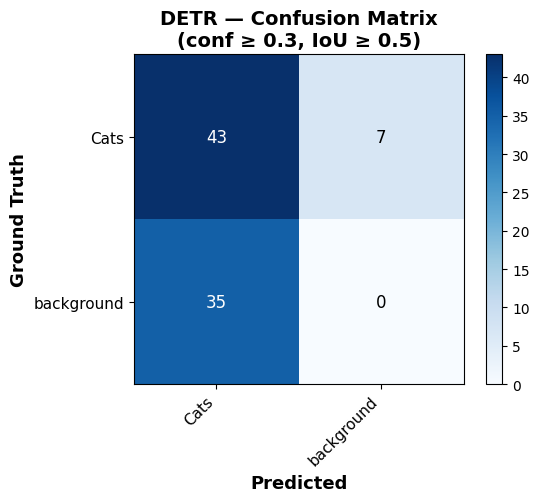


📊 Per-class Detection Stats  (conf ≥ 0.3, IoU ≥ 0.5)
Class                    TP     FP     FN  Precision     Recall
------------------------------------------------------------
Cats                     43     35      7      0.551      0.860


In [ ]:
# ============================================================
# ANALYSIS: Confusion Matrix on Validation Set
# ============================================================
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

# ── Config ───────────────────────────────────────────────────
CONF_THRESHOLD = CONFIDENCE_THRESHOLD  # from configuration cell
# IOU_THRESHOLD already defined in configuration cell

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

# Class labels (index 0 = first object class, last = "background/no-object")
class_names = list(id2label.values())  # e.g. ["cat"]
all_class_names = class_names + ["background"]
num_classes = len(class_names)

# ── IoU helper ───────────────────────────────────────────────
def box_iou_single(boxA, boxB):
    """IoU between two [x1,y1,x2,y2] boxes."""
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0.0

# ── Run inference on validation set ─────────────────────────
# confusion matrix size: (num_classes+1) × (num_classes+1)
# rows = GT class, cols = predicted class  (last index = background)
conf_mat = np.zeros((num_classes + 1, num_classes + 1), dtype=int)

print(f"🔍 Running inference on {len(val_dataset)} validation images...")

for idx in range(len(val_dataset)):
    sample = val_dataset[idx]
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # Post-process
    orig_size = torch.tensor([[pixel_values.shape[-2], pixel_values.shape[-1]]])
    results = processor.post_process_object_detection(
        outputs, threshold=CONF_THRESHOLD, target_sizes=orig_size
    )[0]

    # Apply NMS
    if len(results["boxes"]) > 0:
        pred_boxes, pred_scores, pred_labels = apply_nms(
            results["boxes"], results["scores"], results["labels"],
            iou_threshold=IOU_THRESHOLD
        )
    else:
        pred_boxes  = results["boxes"]
        pred_scores = results["scores"]
        pred_labels = results["labels"]

    pred_boxes  = pred_boxes.cpu().numpy()
    pred_labels = pred_labels.cpu().numpy()

    # Ground-truth for this image
    gt_labels = sample["labels"]["class_labels"].numpy()
    gt_boxes  = sample["labels"]["boxes"].numpy()   # cx,cy,w,h normalized

    # Convert GT boxes from cxcywh (norm) → xyxy (pixels)
    H, W = pixel_values.shape[-2], pixel_values.shape[-1]
    gt_boxes_xyxy = np.stack([
        (gt_boxes[:, 0] - gt_boxes[:, 2] / 2) * W,
        (gt_boxes[:, 1] - gt_boxes[:, 3] / 2) * H,
        (gt_boxes[:, 0] + gt_boxes[:, 2] / 2) * W,
        (gt_boxes[:, 1] + gt_boxes[:, 3] / 2) * H,
    ], axis=1) if len(gt_boxes) > 0 else np.zeros((0, 4))

    # Match predictions to GT
    matched_gt = set()
    matched_pred = set()

    for pi, (pbox, plabel) in enumerate(zip(pred_boxes, pred_labels)):
        best_iou, best_gi = 0.0, -1
        for gi, gbox in enumerate(gt_boxes_xyxy):
            if gi in matched_gt:
                continue
            iou = box_iou_single(pbox, gbox)
            if iou > best_iou:
                best_iou, best_gi = iou, gi

        if best_iou >= IOU_THRESHOLD and best_gi != -1:
            gt_cls   = int(gt_labels[best_gi])
            pred_cls = int(plabel)
            conf_mat[gt_cls, pred_cls] += 1
            matched_gt.add(best_gi)
            matched_pred.add(pi)
        else:
            # False positive → GT=background, pred=plabel
            pred_cls = int(plabel)
            conf_mat[num_classes, pred_cls] += 1

    # Unmatched GT → false negatives (GT=gt_cls, pred=background)
    for gi, glabel in enumerate(gt_labels):
        if gi not in matched_gt:
            conf_mat[int(glabel), num_classes] += 1

print("✅ Inference complete.")

# ── Plot ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(max(6, num_classes + 3), max(5, num_classes + 2)))

im = ax.imshow(conf_mat, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(num_classes + 1)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(all_class_names, rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(all_class_names, fontsize=11)

# Annotate cells
thresh = conf_mat.max() / 2.0
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, str(conf_mat[i, j]),
                ha="center", va="center", fontsize=12,
                color="white" if conf_mat[i, j] > thresh else "black")

ax.set_ylabel("Ground Truth",  fontsize=13, fontweight="bold")
ax.set_xlabel("Predicted",     fontsize=13, fontweight="bold")
ax.set_title(f"DETR — Confusion Matrix\n(conf ≥ {CONF_THRESHOLD}, IoU ≥ {IOU_THRESHOLD})",
             fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), dpi=150, bbox_inches="tight")
plt.show()

# ── Per-class stats ───────────────────────────────────────────
print(f"\n📊 Per-class Detection Stats  (conf ≥ {CONF_THRESHOLD}, IoU ≥ {IOU_THRESHOLD})")
print(f"{'Class':<20} {'TP':>6} {'FP':>6} {'FN':>6} {'Precision':>10} {'Recall':>10}")
print("-" * 60)
for c, name in enumerate(class_names):
    TP = conf_mat[c, c]
    FP = conf_mat[num_classes, c]    # background predicted as this class
    FN = conf_mat[c, num_classes]    # this class predicted as background
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    print(f"{name:<20} {TP:>6} {FP:>6} {FN:>6} {prec:>10.3f} {rec:>10.3f}")

In [ ]:
# ============================================================
# EVALUATION: mAP on Validation Set
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

metric = MeanAveragePrecision(iou_type="bbox", box_format="xyxy")

print(f"📊 Running mAP evaluation on {len(val_dataset)} validation images...")

for idx in range(len(val_dataset)):
    sample   = val_dataset[idx]
    gt_dict  = sample["labels"]
    img_h, img_w = gt_dict["orig_size"].tolist()

    # Ground truth: normalised cxcywh → absolute xyxy
    cx, cy, gw, gh = gt_dict["boxes"].unbind(-1)
    gt_boxes = torch.stack([
        (cx - gw/2) * img_w, (cy - gh/2) * img_h,
        (cx + gw/2) * img_w, (cy + gh/2) * img_h,
    ], dim=-1)

    target = [{"boxes": gt_boxes, "labels": gt_dict["class_labels"]}]

    # Prediction
    image_pil = Image.open(val_dataset.image_files[idx]).convert("RGB")
    inputs    = processor(images=image_pil, return_tensors="pt")
    inputs    = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    target_sizes = torch.tensor([image_pil.size[::-1]]).to(device)
    res = processor.post_process_object_detection(
        outputs, threshold=0.0, target_sizes=target_sizes)[0]

    # NMS
    if len(res["scores"]) > 0:
        b, s, l = apply_nms(res["boxes"], res["scores"], res["labels"],
                            iou_threshold=IOU_THRESHOLD)
    else:
        b, s, l = res["boxes"], res["scores"], res["labels"]

    preds = [{"boxes": b.cpu(), "scores": s.cpu(), "labels": l.cpu()}]
    metric.update(preds, target)

results_map = metric.compute()

map50   = results_map["map_50"].item()
map5095 = results_map["map"].item()
mar100  = results_map["mar_100"].item()

print("\n" + "="*70)
print("VALIDATION METRICS — DETR")
print("="*70)
print(f"  mAP@0.5        : {map50:.4f}")
print(f"  mAP@0.5:0.95   : {map5095:.4f}")
print(f"  Recall@100     : {mar100:.4f}")
print("="*70)

# Save
with open(os.path.join(OUTPUT_DIR, "eval_metrics.json"), "w") as f:
    json.dump({k: v.item() if hasattr(v,"item") else str(v)
               for k,v in results_map.items()}, f, indent=2)
print(f"\n💾 Metrics saved to {OUTPUT_DIR}/eval_metrics.json")


📊 Running mAP evaluation on 43 validation images...

VALIDATION METRICS — DETR
  mAP@0.5        : 0.7587
  mAP@0.5:0.95   : 0.4172
  Recall@100     : 0.5920

💾 Metrics saved to ./detr_finetuned/eval_metrics.json


In [ ]:
# ============================================================
# TEST: Load Model
# ============================================================

print("\n" + "="*70)
print("🧪 START TESTING")
print("="*70 + "\n")

# Check model existence
if not os.path.exists(OUTPUT_DIR):
    raise ValueError(
        f"❌ Model not found at {OUTPUT_DIR}\n"
        "💡 First run the TRAINING section!"
    )

# Load model
print("📦 Loading trained model...")
processor = DetrImageProcessor.from_pretrained(OUTPUT_DIR)
model = DetrForObjectDetection.from_pretrained(OUTPUT_DIR)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"✅ Model loaded on: {device}")
print(f"📋 Recognized classes: {list(processor.id2label.values())}")


🧪 START TESTING

📦 Loading trained model...


✅ Model loaded on: cuda
📋 Recognized classes: ['Cats']


In [ ]:
# ============================================================
# DIAGNOSIS: Check raw predictions (without threshold)
# ============================================================

sample = val_dataset[0]
pixel_values = sample["pixel_values"].unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# Check top-10 scores WITHOUT any threshold
probs = outputs.logits.softmax(-1)[0, :, :-1]  # exclude no-object class
scores, labels = probs.max(-1)
top10 = scores.topk(10)

print("Top 10 prediction scores (no threshold applied):")
for score, idx in zip(top10.values, top10.indices):
    label_name = list(id2label.values())[labels[idx]]
    print(f"  query {idx.item():3d}: {label_name} = {score.item():.4f}")

print(f"\nHighest score overall  : {scores.max().item():.4f}")
print(f"Current threshold      : {CONFIDENCE_THRESHOLD}")

if scores.max().item() < 0.15:
    print("\n⚠️  Model has NOT converged — retrain with more epochs!")
elif scores.max().item() < CONFIDENCE_THRESHOLD:
    print(f"\n⚠️  Model learned something but threshold {CONFIDENCE_THRESHOLD} is too high.")
    print(f"   Try lowering CONFIDENCE_THRESHOLD to {scores.max().item():.2f} or less.")
else:
    print("\n✅ Model is producing predictions above the threshold.")

Top 10 prediction scores (no threshold applied):
  query  98: Cats = 0.9181
  query  59: Cats = 0.8992
  query  45: Cats = 0.7236
  query   5: Cats = 0.4906
  query  71: Cats = 0.1538
  query  72: Cats = 0.1407
  query  95: Cats = 0.0678
  query  58: Cats = 0.0569
  query  51: Cats = 0.0396
  query  47: Cats = 0.0322

Highest score overall  : 0.9181
Current threshold      : 0.3

✅ Model is producing predictions above the threshold.



🖼️  Found 20 test images


──────────────────────────────────────────────────────────────────────
📸 Test 1/20: cat-0.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (180, 281)
   🎯 Objects detected: 1
      • Class_0: 0.982
   📊 Showing 1 detections above threshold 0.3


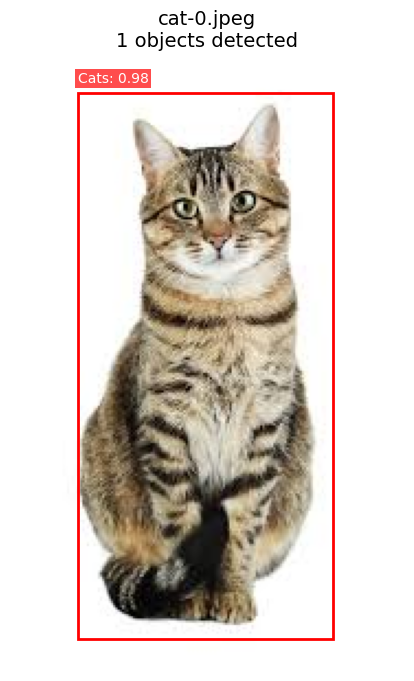


──────────────────────────────────────────────────────────────────────
📸 Test 2/20: cat-camouflaged-10.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (296, 170)
   🎯 Objects detected: 1
      • Class_0: 0.990
   📊 Showing 1 detections above threshold 0.3


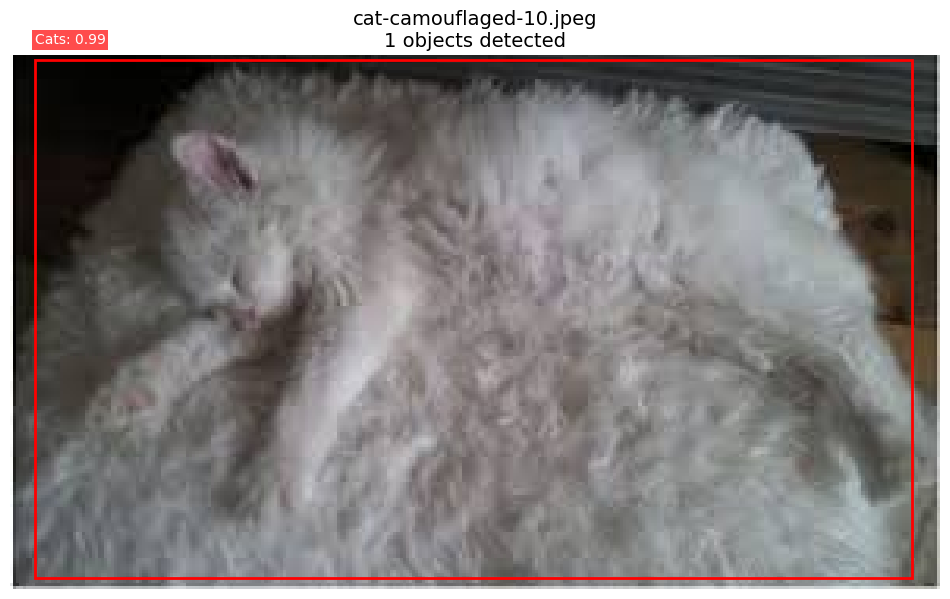


──────────────────────────────────────────────────────────────────────
📸 Test 3/20: cat-camouflaged-9.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 1
      • Class_0: 0.895
   📊 Showing 1 detections above threshold 0.3


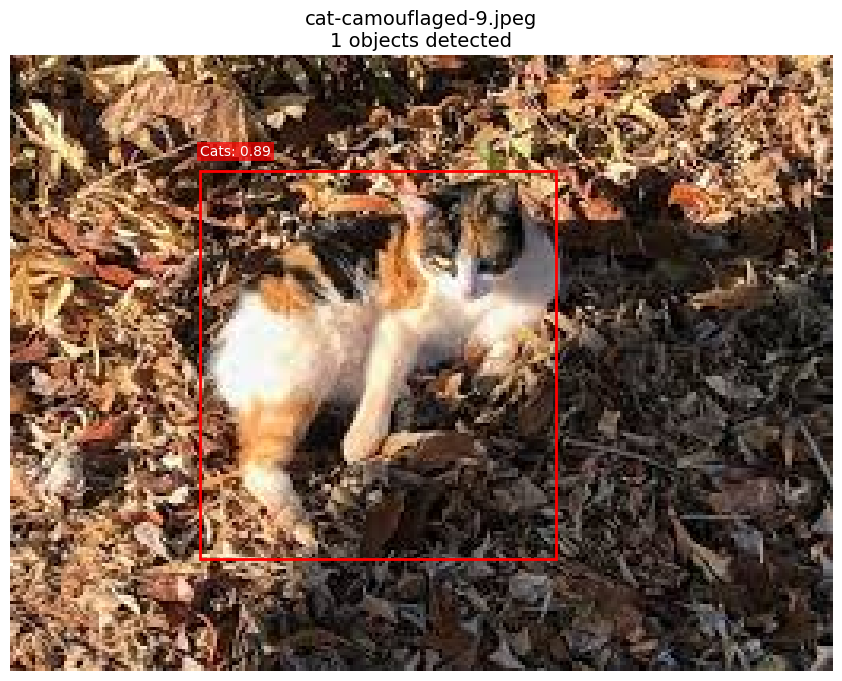


──────────────────────────────────────────────────────────────────────
📸 Test 4/20: cat-1.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (308, 164)
   🎯 Objects detected: 2
      • Class_0: 0.619
      • Class_0: 0.968
   📊 Showing 2 detections above threshold 0.3


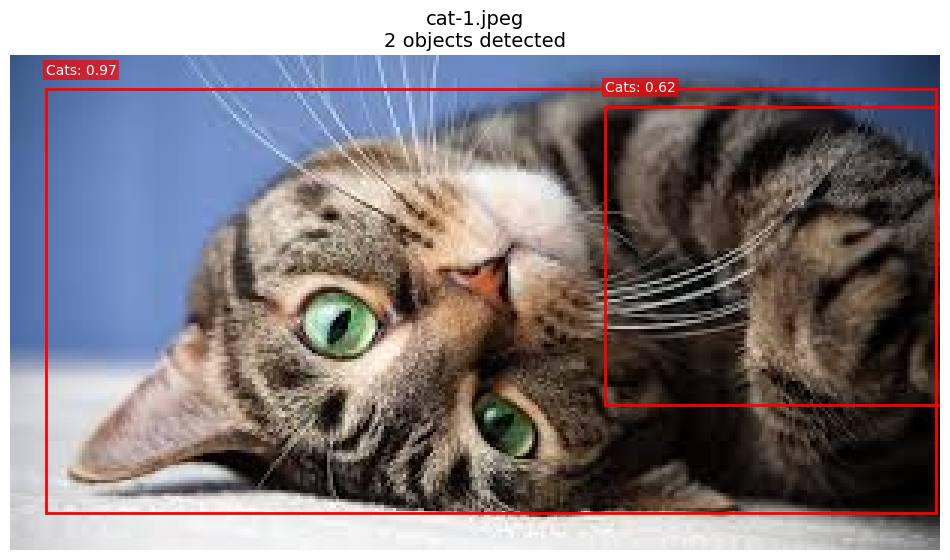


──────────────────────────────────────────────────────────────────────
📸 Test 5/20: cat-camouflaged-4.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 2
      • Class_0: 0.551
      • Class_0: 0.988
   📊 Showing 2 detections above threshold 0.3


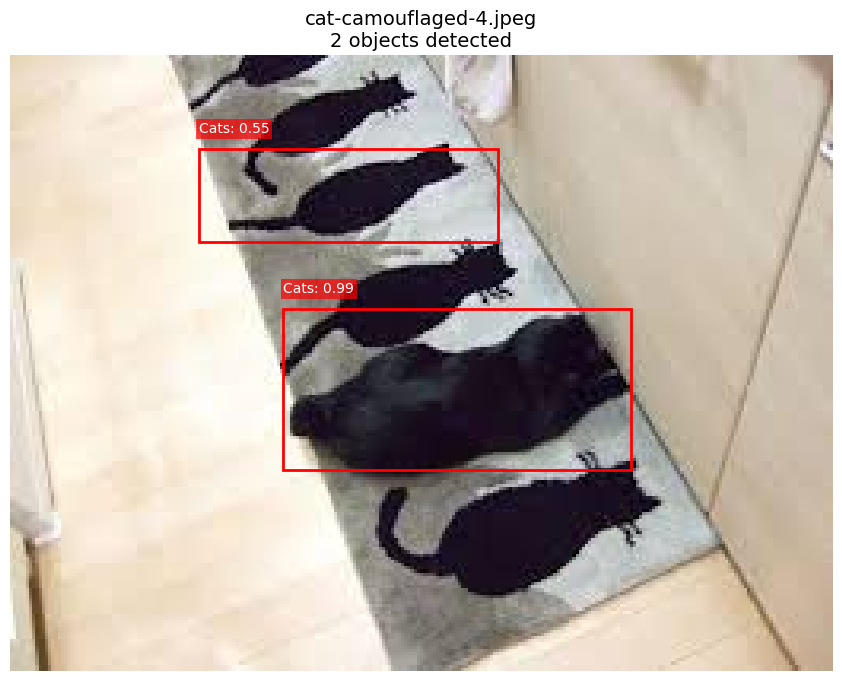


──────────────────────────────────────────────────────────────────────
📸 Test 6/20: cat-camouflaged-6.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 1
      • Class_0: 0.973
   📊 Showing 1 detections above threshold 0.3


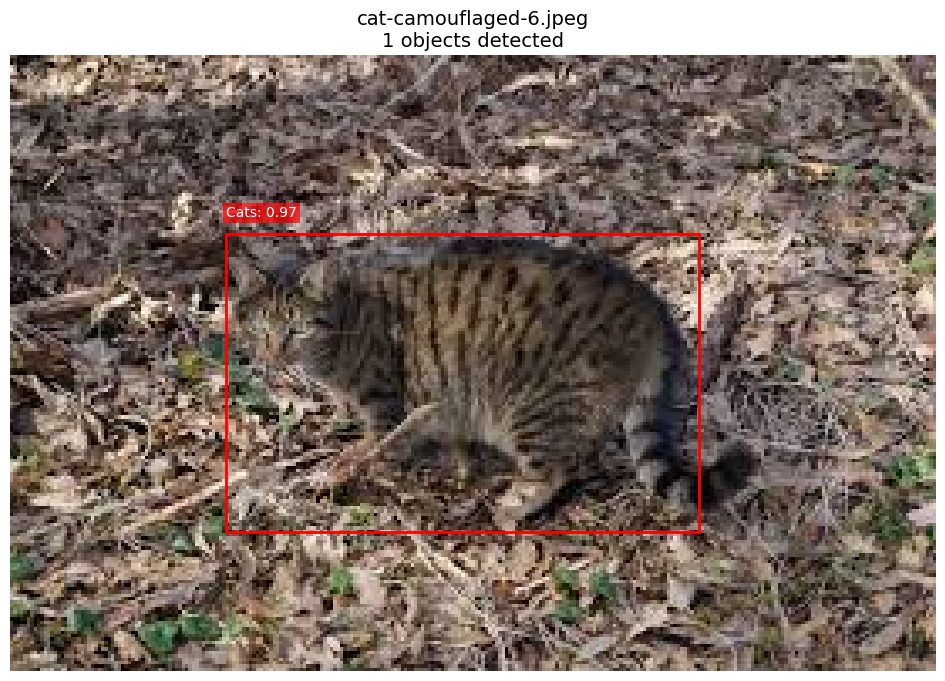


──────────────────────────────────────────────────────────────────────
📸 Test 7/20: cat-6.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (284, 178)
   🎯 Objects detected: 0
   ⚠️  No objects detected above confidence threshold


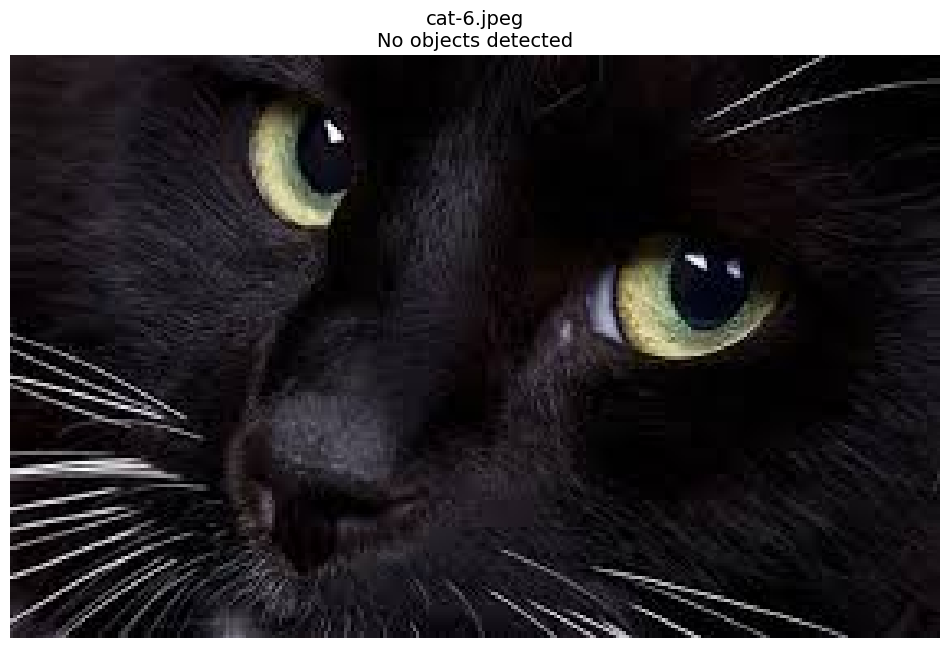


──────────────────────────────────────────────────────────────────────
📸 Test 8/20: cat-camouflaged-3.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (223, 226)
   🎯 Objects detected: 1
      • Class_0: 0.839
   📊 Showing 1 detections above threshold 0.3


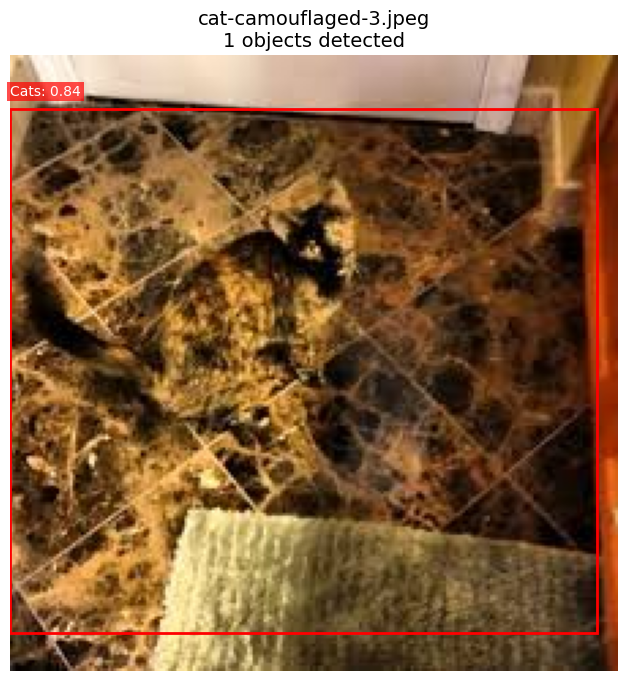


──────────────────────────────────────────────────────────────────────
📸 Test 9/20: cat-5.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 1
      • Class_0: 0.937
   📊 Showing 1 detections above threshold 0.3


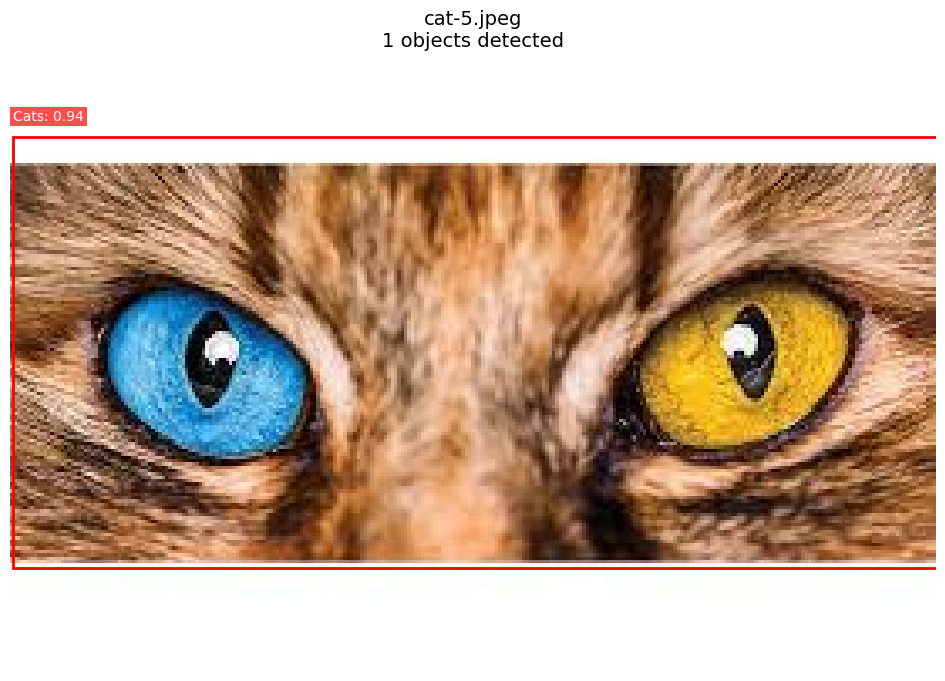


──────────────────────────────────────────────────────────────────────
📸 Test 10/20: cat-7.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (202, 250)
   🎯 Objects detected: 3
      • Class_0: 0.592
      • Class_0: 0.820
      • Class_0: 0.913
   📊 Showing 3 detections above threshold 0.3


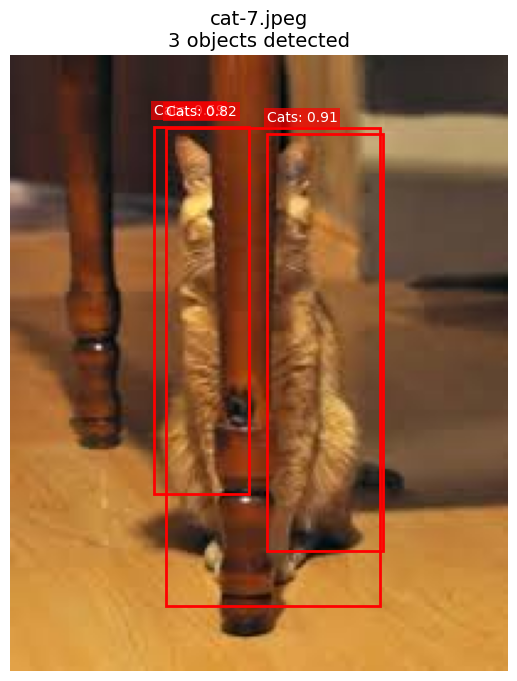


──────────────────────────────────────────────────────────────────────
📸 Test 11/20: cat-camouflaged-7.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 1
      • Class_0: 0.983
   📊 Showing 1 detections above threshold 0.3


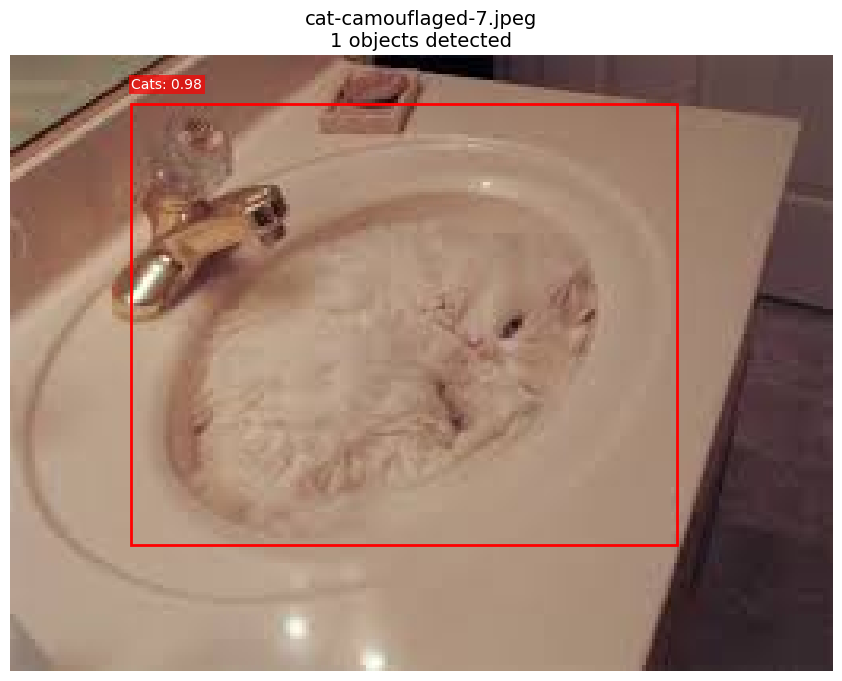


──────────────────────────────────────────────────────────────────────
📸 Test 12/20: cat-2.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 1
      • Class_0: 0.981
   📊 Showing 1 detections above threshold 0.3


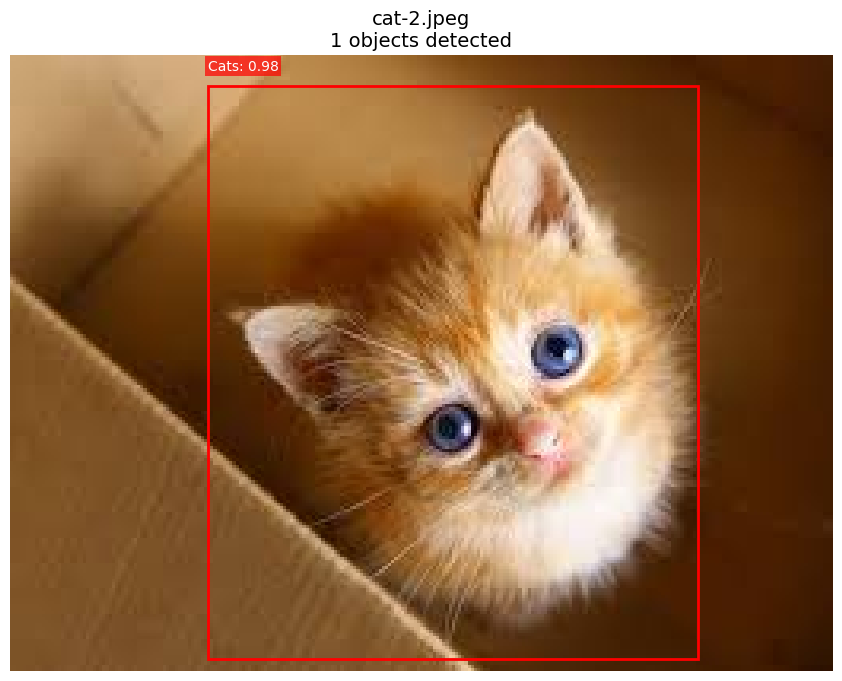


──────────────────────────────────────────────────────────────────────
📸 Test 13/20: cat-camouflaged-11.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (262, 192)
   🎯 Objects detected: 2
      • Class_0: 0.736
      • Class_0: 0.955
   📊 Showing 2 detections above threshold 0.3


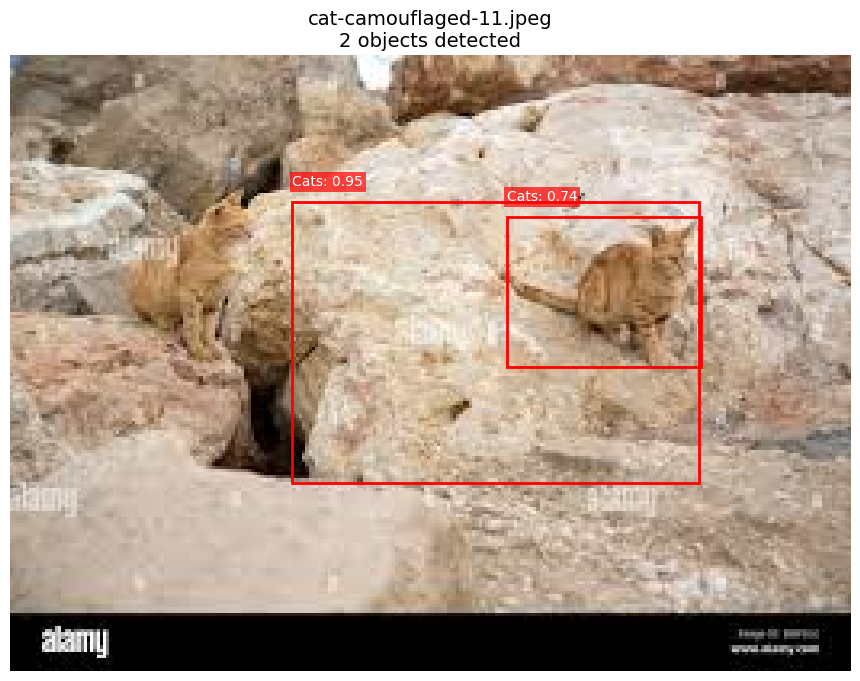


──────────────────────────────────────────────────────────────────────
📸 Test 14/20: cat-camouflaged-2.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (241, 209)
   🎯 Objects detected: 1
      • Class_0: 0.987
   📊 Showing 1 detections above threshold 0.3


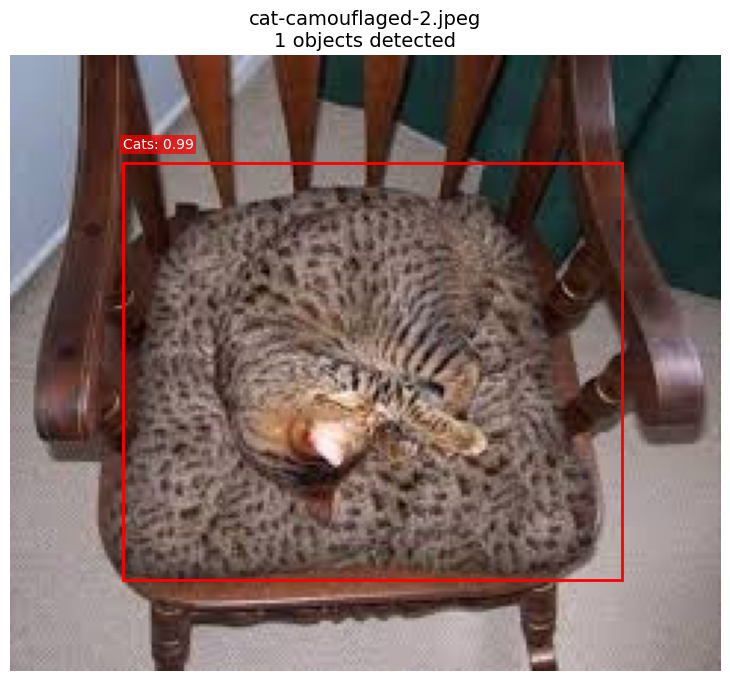


──────────────────────────────────────────────────────────────────────
📸 Test 15/20: cat-camouflaged-1.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (264, 191)
   🎯 Objects detected: 1
      • Class_0: 0.952
   📊 Showing 1 detections above threshold 0.3


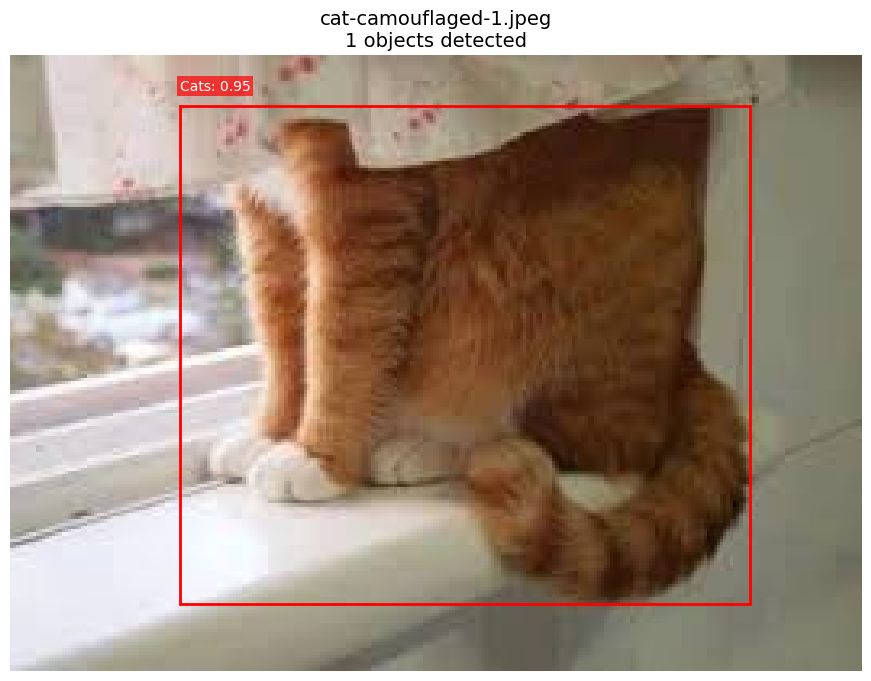


──────────────────────────────────────────────────────────────────────
📸 Test 16/20: cat-camouflaged-8.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 4
      • Class_0: 0.812
      • Class_0: 0.721
      • Class_0: 0.576
      • Class_0: 0.928
   📊 Showing 4 detections above threshold 0.3


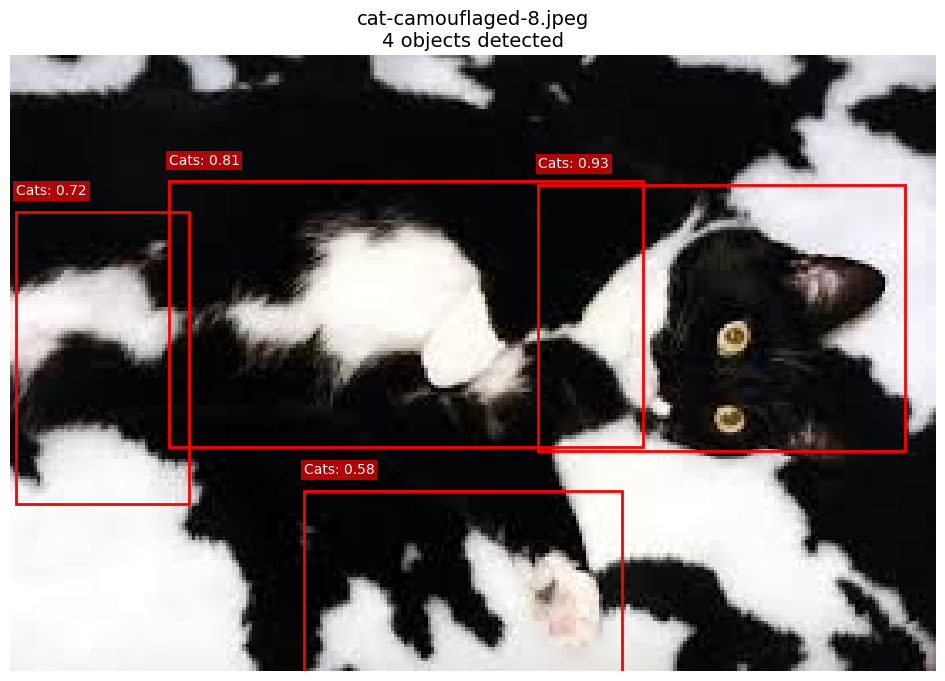


──────────────────────────────────────────────────────────────────────
📸 Test 17/20: cat-4.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (270, 187)
   🎯 Objects detected: 1
      • Class_0: 0.941
   📊 Showing 1 detections above threshold 0.3


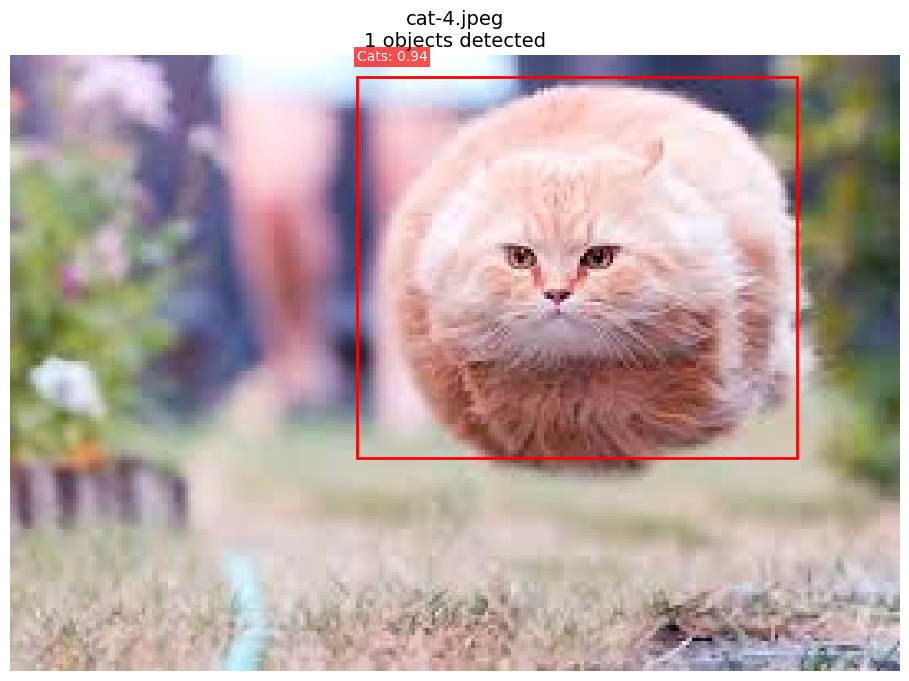


──────────────────────────────────────────────────────────────────────
📸 Test 18/20: cat-3.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (294, 172)
   🎯 Objects detected: 1
      • Class_0: 0.984
   📊 Showing 1 detections above threshold 0.3


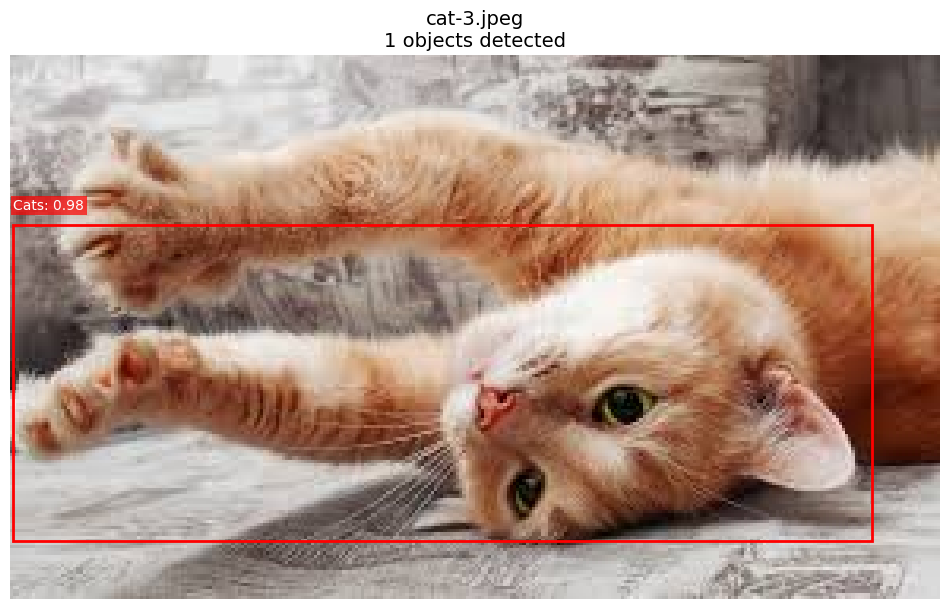


──────────────────────────────────────────────────────────────────────
📸 Test 19/20: cat-camouflaged-5.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (224, 225)
   🎯 Objects detected: 2
      • Class_0: 0.882
      • Class_0: 0.964
   📊 Showing 2 detections above threshold 0.3


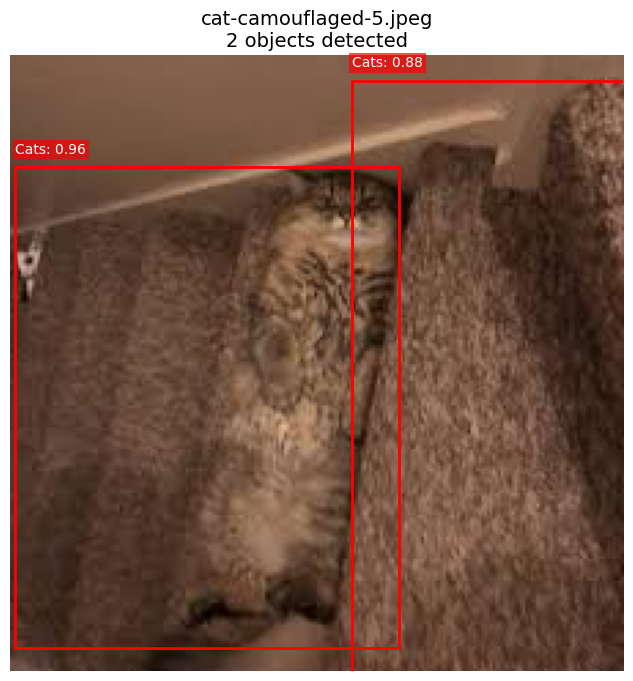


──────────────────────────────────────────────────────────────────────
📸 Test 20/20: owl.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (268, 188)
   🎯 Objects detected: 3
      • Class_0: 0.392
      • Class_0: 0.361
      • Class_0: 0.693
   📊 Showing 3 detections above threshold 0.3


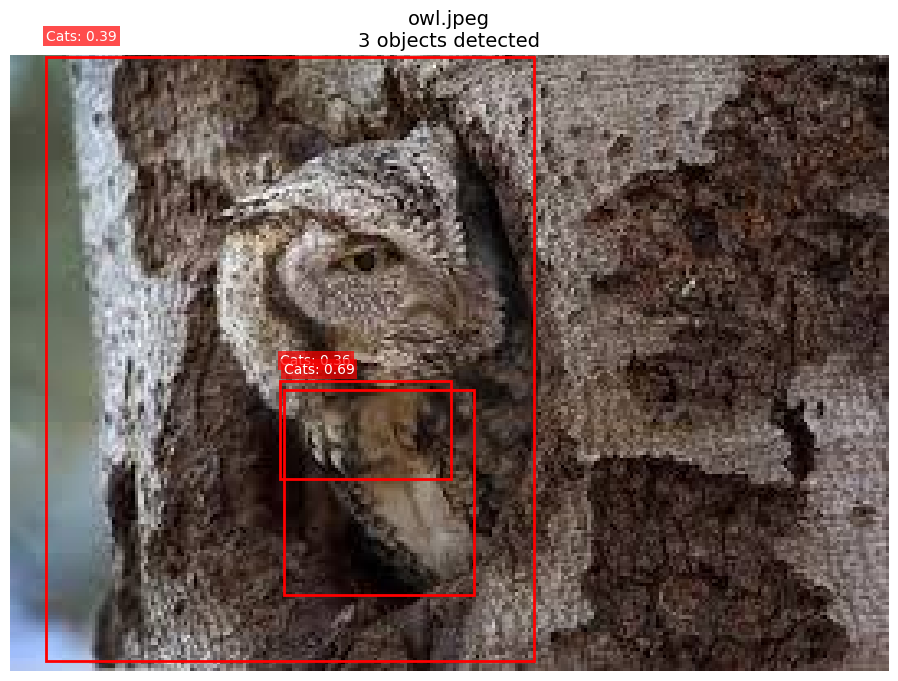


✅ TESTING COMPLETED!



In [ ]:
# ============================================================
# TEST: Run Inference
# ============================================================

# Find test images
test_images_path = Path(TEST_IMAGES_DIR)
image_files = (list(test_images_path.glob('*.jpg')) +
               list(test_images_path.glob('*.png')) +
               list(test_images_path.glob('*.jpeg')))

if not image_files:
    print(f"❌ No images found in {TEST_IMAGES_DIR}")
else:
    print(f"\n🖼️  Found {len(image_files)} test images\n")

    # Test each image
    for idx, img_path in enumerate(image_files, 1):
        print(f"\n{'─'*70}")
        print(f"📸 Test {idx}/{len(image_files)}: {img_path.name}")
        print(f"{'─'*70}")

        try:
            # Load image
            image = Image.open(img_path).convert("RGB")
            print(f"   Dimensions: {image.size}")

            # Preprocess
            inputs = processor(images=image, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Post-process
            target_sizes = torch.tensor([image.size[::-1]]).to(device)
            results = processor.post_process_object_detection(
                outputs,
                threshold=CONFIDENCE_THRESHOLD,
                target_sizes=target_sizes
            )[0]

            # Apply NMS to remove duplicate detections
            if len(results["scores"]) > 0:
                boxes_nms, scores_nms, labels_nms = apply_nms(
                    results["boxes"],
                    results["scores"],
                    results["labels"],
                    iou_threshold=IOU_THRESHOLD
                )

                results = {
                    "boxes": boxes_nms,
                    "scores": scores_nms,
                    "labels": labels_nms
                }

            # Show results
            num_detections = len(results["scores"])
            print(f"   🎯 Objects detected: {num_detections}")

            if num_detections > 0:
                # Print detections
                for score, label, box in zip(
                    results["scores"],
                    results["labels"],
                    results["boxes"]
                ):
                    label_name = processor.id2label.get(label.item(), f"Class_{label.item()}")
                    print(f"      • {label_name}: {score:.3f}")

                # Visualize with bounding boxes
                fig = visualize_predictions(
                    image, results, processor, CONFIDENCE_THRESHOLD
                )
                plt.title(f"{img_path.name}\n{num_detections} objects detected", fontsize=14)
                plt.show()

            else:
                print("   ⚠️  No objects detected above confidence threshold")
                # Show image anyway (without boxes)
                plt.figure(figsize=(12, 8))
                plt.imshow(image)
                plt.title(f"{img_path.name}\nNo objects detected", fontsize=14)
                plt.axis('off')
                plt.show()

        except Exception as e:
            print(f"   ❌ Error: {e}")
            import traceback
            traceback.print_exc()
            continue

    print(f"\n{'='*70}")
    print("✅ TESTING COMPLETED!")
    print(f"{'='*70}\n")